In [1]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np
import mshr
import ufl
import itertools

### Mesh, periodic boundary, material parameters

In [2]:
# Create the mesh for laminate microstructure
vertices = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])

square = mshr.Rectangle(Point(0, 0), Point(1, 1))
strip = mshr.Rectangle(Point(0.25, -1), Point(0.75, 1))

square.set_subdomain(1, strip)
mesh = mshr.generate_mesh(square, 24)
subdomain_marker = MeshFunction(
    'size_t', mesh, mesh.topology().dim(), mesh.domains())

# Compute volume of RVE
a = np.zeros((2, 2))      # direction vectors that define RVE.
a[0,:] = vertices[1,:] - vertices[0,:]
a[1,:] = vertices[3,:] - vertices[0,:]
vol = np.linalg.det(a);

# class used to define the periodic boundary map
class PeriodicBoundary(SubDomain):
    # Constructor
    def __init__(self, vertices, TOL=DOLFIN_EPS_LARGE):
        super().__init__()
        self.TOL = TOL
        self.vertices = vertices
        # vectors generating periodicity
        self.a = np.array([vertices[1,:] - vertices[0,:],
                          vertices[3,:] - vertices[0,:]])
        
        # vectors normal to vectors a[0,:] and a[1,:]
        self.n = np.array([[ -self.a[0,1], self.a[0,0] ], 
                          [ -self.a[1,1], self.a[1,0] ]])
        
    def inside(self, x, on_boundary):
        # return True if x is on the left or bottom boundaries
        # AND NOT on one of the bottom-right or top-left vertices
        top_left = np.allclose(x, self.vertices[3,:])
        bottom_right = np.allclose(x, self.vertices[1,:])
        x_vector = x - self.vertices[0,:]
        bottom = np.abs(np.dot(self.n[0,:], x_vector)) < self.TOL
        left = np.abs(np.dot(self.n[1,:], x_vector)) < self.TOL
            
        return (left or bottom) and \
            (not (top_left or bottom_right)) and on_boundary
    
    # Map the right to the left, the top to the bottom boundaries
    def map(self, x, y):
        # top right node
        if np.allclose(x, self.vertices[2,:]):
            y[0] = x[0] - (self.a[0, 0] + self.a[1,0])
            y[1] = x[1] - (self.a[0, 1] + self.a[1,1])
        # right boundary
        elif np.abs(np.dot(self.n[1,:], 
                           x - self.vertices[1,:])) < self.TOL:
            y[0] = x[0] - self.a[0,0]
            y[1] = x[1] - self.a[0,1]
        # top boundary
        else:  
            y[0] = x[0] - self.a[1,0]
            y[1] = x[1] - self.a[1,1]

# Create an instance of periodic boundary condition
pbc = PeriodicBoundary(vertices)

In [3]:
# Elastic parameters for two different phases

nu_ = np.array([0.35, 0.32])
chi_ = np.array([1.0, 10.0])
mu_ = np.array([1.0, 10.0])
beta_ = 2*nu_/(1 - 2*nu_)
EPS0 = 8.854

class ParameterFunc(UserExpression):
    def __init__(self, subdomain_marker, para_values, **kwargs):
        super().__init__(**kwargs)
        self.para_values = para_values
        self.subdomain_marker = subdomain_marker
            
    def eval_cell(self, value, x, ufl_cell):
        if self.subdomain_marker[ufl_cell.index] == 0:
            value[0] = self.para_values[0]
        else:
            value[0] = self.para_values[1]
    
    def value_shape(self):
        return ()
    
mu_func = ParameterFunc(subdomain_marker, mu_, degree=2)
beta_func = ParameterFunc(subdomain_marker, beta_, degree=2)
chi_func = ParameterFunc(subdomain_marker, chi_, degree=2)

### Solution using FEniCS nonlinear solver

In [4]:
Elem_Mech = VectorElement("CG", mesh.ufl_cell(), degree=1)
Elem_Elec = FiniteElement("CG", mesh.ufl_cell(), degree=1)
W = FunctionSpace(mesh, MixedElement([Elem_Mech, Elem_Elec]),
                 constrained_domain = pbc)

In [5]:
# Macroscopic deformation gradient
theta = 0
R_Macro_arr = np.array([[np.cos(theta), -np.sin(theta)], 
                        [np.sin(theta), np.cos(theta)]])
U_Macro_arr = np.array([[0.95, 0.05], 
                      [0.05, 1.1]])
F_Macro_arr = np.dot(R_Macro_arr, U_Macro_arr)
E_Macro_arr = np.array([0.2, -0.2])
F_Macro = Constant(F_Macro_arr)
E_Macro = Constant(E_Macro_arr)

In [6]:
(v_1, v_2) = TestFunctions(W)
dsol = TrialFunction(W)
sol = Function(W)
(u, phi) = split(sol)

d = mesh.geometric_dimension()
F = F_Macro + grad(u)
E = E_Macro + grad(phi)
C = F.T * F
J = det(F)
Ic = tr(C)
invC = inv(C)
invF = inv(F)

(i, j, k, l) = ufl.indices(4)

Lambda = invC[0,0]*E[0]*E[0] + invC[0,1]*E[0]*E[1] \
    + invC[1,0]*E[1]*E[0] + invC[1,1]*E[1]*E[1]

Kappa = as_tensor(-(invF[i,k]*invC[l,j] + invF[j,k]*invC[l,i]),
                  (i, j, k, l))

Zeta = as_tensor(Kappa[0,0,i,j]*E[0]*E[0]
    + Kappa[0,1,i,j]*E[0]*E[1] + Kappa[1,0,i,j]*E[1]*E[0]
    + Kappa[1,1,i,j]*E[1]*E[1], (i, j))

# Total stress tensor
P = mu_func * F - mu_func * J**(-beta_func) * invF.T \
    - 0.5*EPS0 * (J* invF.T * Lambda + (J + chi_func) * Zeta)

# Displacement electric vector
D = -EPS0 * (J + chi_func)*dot(invC, E)

# define the volume integral element
dx = Measure('dx', subdomain_data=subdomain_marker)

Residual = inner(grad(v_1), P)*dx + dot(grad(v_2), D)*dx
Jacobian = derivative(Residual, sol, dsol)

solve(Residual == 0, sol, [], J=Jacobian)

In [7]:
F_Micro = project(F_Macro + grad(sol.sub(0)), 
        TensorFunctionSpace(mesh, "DG", degree=1, shape=(2,2)))

E_Micro = project(E_Macro + grad(sol.sub(1)), 
        VectorFunctionSpace(mesh, "DG", degree=1))

F_Micro:
-------------------------------
phase = 0: [0.90310977 0.05       0.12837104 1.1       ]
phase = 1: [ 0.99689023  0.05       -0.02837104  1.1       ]
E_Micro:
-------------------------------
phase = 0: [ 0.3243868 -0.2      ]
phase = 1: [ 0.0756132 -0.2      ]


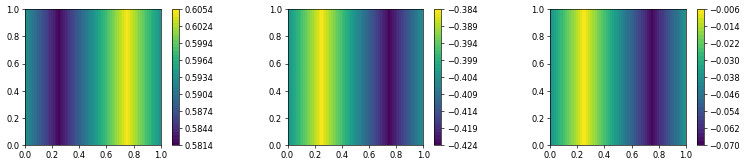

In [14]:
plt.figure(figsize=(16,3), dpi=60)
for i in range(2):
    plt.subplot(1,3,i+1)
    plt.colorbar(plot(sol.sub(0)[i]))
plt.subplot(1,3,3); plt.colorbar(plot(sol.sub(1)))

print("F_Micro:\n-------------------------------")
print("phase = 0:", F_Micro(0.1, 0.5) )
print("phase = 1:", F_Micro(0.5, 0.5) )

print("E_Micro:\n-------------------------------")
print("phase = 0:", E_Micro(0.1, 0.5) )
print("phase = 1:", E_Micro(0.5, 0.5) )

## Macroscopic tangent stiffness

### Microscopic tangent stiffness at equilibrium state

In [15]:
(i, j, k, l) = ufl.indices(4)
d = mesh.geometric_dimension()
I = Identity(d)
F = F_Macro + grad(sol.sub(0))
E = E_Macro + grad(sol.sub(1))
C = F.T * F
J = det(F)
Ic = tr(C)
invC = inv(C)
invF = inv(F)


#=================================================
# Compute intermediate tensors

(i, j, k, l, m, n) = ufl.indices(6)

Lambda = invC[0,0]*E[0]*E[0] + invC[0,1]*E[0]*E[1] \
    + invC[1,0]*E[1]*E[0] + invC[1,1]*E[1]*E[1]

Kappa = as_tensor(-(invF[i,k]*invC[l,j] + invF[j,k]*invC[l,i]),
                  (i, j, k, l))

Zeta = J * invF.T

Omega = as_tensor(Kappa[0,0,i,j]*E[0]*E[0]
    + Kappa[0,1,i,j]*E[0]*E[1] + Kappa[1,0,i,j]*E[1]*E[0]
    + Kappa[1,1,i,j]*E[1]*E[1], (i, j))

Gamma = as_tensor(-invF[i,k]*invF[l,j], (i,j,k,l))

Q1 = as_tensor(invF[m,k]*invF[l,i]*invC[j,n] + invF[m,i]*invF[j,k]*invC[n,l]+invF[m,i]*invF[n,k]*invC[j,l],
              (i,j,k,l,m,n))
Q2 = as_tensor(Q1[i,j,k,l,0,0]*E[0]*E[0] + Q1[i,j,k,l,0,1]*E[0]*E[1] \
               + Q1[i,j,k,l,1,0]*E[1]*E[0] + Q1[i,j,k,l,1,1]*E[1]*E[1], (i,j,k,l))

#=================================================
# Compute microscopic tangent stiffnesses

K_MechMech = as_tensor(mu_func*I[i,k]*I[j,l] - mu_func*J**(-beta_func)*(beta_func*Gamma[l,i,k,j] 
    + Gamma[j,i,k,l]) - 0.5*EPS0*(J*Lambda*(Gamma[j,i,k,l] - Gamma[l,i,k,j]) + Zeta[i,j]*Omega[k,l] 
    + Zeta[k,l]*Omega[i,j] + 2*(J+chi_func)*Q2[i,j,k,l]), (i,j,k,l))

K_ElecMech = as_tensor(-EPS0*(Zeta[k,l] * (invC[i,0]*E[0]+invC[i,1]*E[1]) 
                       + (J + chi_func)*(Kappa[i,0,k,l]*E[0] + Kappa[i,1,k,l]*E[1])), (i, k, l))

K_MechElec = as_tensor(K_ElecMech[i,k,l], (k, l, i))

K_ElecElec = -EPS0*(J + chi_func)*invC

### Fluctuation sensitivities

In [91]:
du, dphi = TrialFunctions(W)
v_1, v_2 = TestFunctions(W)

# bilinear form corresponding to equation 
# for fluctuation sensitivities
a = 0
for (i1, i2, i3, i4) in itertools.product([0, 1], repeat=4):
    a += v_1[i1].dx(i2) * K_MechMech[i1, i2, i3, i4] \
    * du[i3].dx(i4) * dx
    
for (i1, i2, i3) in itertools.product([0, 1], repeat=3):
    a += v_1[i1].dx(i2)*K_MechElec[i1,i2,i3]*dphi.dx(i3) * dx \
        + v_2.dx(i3) * K_ElecMech[i3,i1,i2] * du[i1].dx(i2) * dx

for (i1, i2) in itertools.product([0, 1], repeat=2):
    a += v_2.dx(i1) * K_ElecElec[i1, i2] * dphi.dx(i2) * dx
    
# linear form for fluctuation sensitivities
# ==========================================
# linearization w.r.t. Macroscopic F
sol_fluc_F_list = [Function(W) for i in range(4)]

for (r, s) in itertools.product([0, 1], repeat=2):
    L = 0
    for (i1, i2) in itertools.product([0, 1], repeat=2):
        L -= v_1[i1].dx(i2) * K_MechMech[i1,i2,r,s] * dx    
    for i1 in range(2):
        L -= v_2.dx(i1) * K_ElecMech[i1,r,s] * dx
    
    solve(a == L, sol_fluc_F_list[2*r+s], [])
    
# ==========================================
# linearization w.r.t. Macroscopic E
sol_fluc_E_list = [Function(W) for i in range(2)]

for r in range(2):
    L = 0
    for (i1, i2) in itertools.product([0, 1], repeat=2):
        L -= v_1[i1].dx(i2) * K_MechElec[i1,i2,r] * dx
    for i1 in range(2):
        L -= v_2.dx(i1) * K_ElecElec[i1,r] * dx
    
    solve(a == L, sol_fluc_E_list[r], [])

In [95]:
print("Fluctuation sensitivities w.r.t. F_Macro")
print("========================================")
for (r, s) in itertools.product([0, 1], repeat=2):
    u_fluc_F, phi_fluc_F = split(sol_fluc_F_list[2*r+s])
    # dFfluc_dFmacro = grad(u_fluc_F)
    # dEfluc_dFmacro = grad(phi_fluc_F)
    
    dFfluc_dFmacro = project(grad(u_fluc_F), 
                            TensorFunctionSpace(mesh, "DG", degree=2, shape=(2,2)))
    dEfluc_dFmacro = project(grad(phi_fluc_F), 
                            VectorFunctionSpace(mesh, "DG", degree=2))
    
    print("----------",(r+1, s+1),"----------")
    print("Phase 0: ", np.round(dFfluc_dFmacro(0.125, 0.5), 13))
    print("Phase 1: ", np.round(dFfluc_dFmacro(0.5,   0.5), 13))
    print("Phase 0: ", np.round(dEfluc_dFmacro(0.125, 0.5), 13))
    print("Phase 0: ", np.round(dEfluc_dFmacro(0.5,   0.5), 13))
    print("----------------------------\n")
    

print("Fluctuation sensitivities w.r.t. E_Macro")
print("========================================")
for r in range(2):
    u_fluc_F, phi_fluc_F = split(sol_fluc_E_list[r])
    # dFfluc_dFmacro = grad(u_fluc_F)
    # dEfluc_dFmacro = grad(phi_fluc_F)
    
    dFfluc_dEmacro = project(grad(u_fluc_F), 
                            TensorFunctionSpace(mesh, "DG", degree=2, shape=(2,2)))
    dEfluc_dEmacro = project(grad(phi_fluc_F), 
                            VectorFunctionSpace(mesh, "DG", degree=2))
    
    print("----------",(r+1, s+1),"----------")
    print("Phase 0: ", np.round(dFfluc_dEmacro(0.125, 0.5), 13))
    print("Phase 1: ", np.round(dFfluc_dEmacro(0.5,   0.5), 13))
    print("Phase 0: ", np.round(dEfluc_dEmacro(0.125, 0.5), 13))
    print("Phase 0: ", np.round(dEfluc_dEmacro(0.5,   0.5), 13))
    print("----------------------------\n")
    


Fluctuation sensitivities w.r.t. F_Macro
---------- (1, 1) ----------
Phase 0:  [ 0.92048876 -0.         -0.00465032  0.        ]
Phase 1:  [-0.92048876 -0.          0.00465032  0.        ]
Phase 0:  [ 0.19605829 -0.        ]
Phase 0:  [-0.19605829 -0.        ]
----------------------------

---------- (1, 2) ----------
Phase 0:  [-0.02851145  0.          0.75053502  0.        ]
Phase 1:  [ 0.02851145  0.         -0.75053502 -0.        ]
Phase 0:  [-0.0583028 -0.       ]
Phase 0:  [ 0.0583028 -0.       ]
----------------------------

---------- (2, 1) ----------
Phase 0:  [-0.08360249  0.          0.82198193  0.        ]
Phase 1:  [ 0.08360249  0.         -0.82198193 -0.        ]
Phase 0:  [-0.06005575 -0.        ]
Phase 0:  [ 0.06005575 -0.        ]
----------------------------

---------- (2, 2) ----------
Phase 0:  [ 0.31426335 -0.         -0.04834102  0.        ]
Phase 1:  [-0.31426335 -0.          0.04834102 -0.        ]
Phase 0:  [ 0.05445592 -0.        ]
Phase 0:  [-0.05445592 -0

### Macroscopic elastic tangents via fluctuation sensitivities

In [103]:
#===========================
# Derivatives of P_Macro w.r.t. F_Macro
C_MechMech = np.zeros((2, 2, 2, 2))
# Derivatives of D_Macro w.r.t. F_Macro
C_ElecMech = np.zeros((2, 2, 2))
# Derivatives of P_Macro w.r.t. E_Macro
C_MechElec = np.zeros((2, 2, 2))
# Derivatives of D_Macro w.r.t. E_Macro
C_ElecElec = np.zeros((2, 2))

# Compute C_MechMech
for (i1, i2, i3, i4) in itertools.product([0, 1], repeat=4):
    integrand = K_MechMech[i1, i2, i3, i4] * dx
    u_fluc_F, phi_fluc_F= split(sol_fluc_F_list[2*i3+i4])
    for (j1, j2) in itertools.product([0, 1], repeat=2):
        integrand += K_MechMech[i1,i2,j1,j2] * u_fluc_F[j1].dx(j2) * dx
    for j1 in range(2):
        integrand += K_MechElec[i1,i2,j1] * phi_fluc_F.dx(j1) * dx
    
    C_MechMech[i1,i2,i3,i4] = assemble(integrand) / vol

# Compute C_ElecMech
for (i1, i2, i3) in itertools.product([0, 1], repeat=3):
    integrand = K_ElecMech[i1, i2, i3] * dx
    u_fluc_F, phi_fluc_F = split(sol_fluc_F_list[2*i2 + i3])
    for (j1, j2) in itertools.product([0, 1], repeat=2):
        integrand += K_ElecMech[i1,j1,j2] * u_fluc_F[j1].dx(j2) * dx
    for j1 in range(2):
        integrand += K_ElecElec[i1,j1] * phi_fluc_F.dx(j1) * dx
        
    C_ElecMech[i1,i2,i3] = assemble(integrand) / vol
    
# Compute C_ElecElec
for (i1, i2) in itertools.product([0, 1], repeat=2):
    integrand = K_ElecElec[i1,i2] * dx
    u_fluc_E, phi_fluc_E = split(sol_fluc_E_list[i2])
    for (j1, j2) in itertools.product([0, 1], repeat=2):
        integrand += K_ElecMech[i1,j1,j2] * u_fluc_E[j1].dx(j2) * dx
    for j1 in range(2):
        integrand += K_ElecElec[i1,j1] * phi_fluc_E.dx(j1) * dx
    
    C_ElecElec[i1,i2] = assemble(integrand) / vol 

Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/coffeemilk/anaconda3/envs/fenics2018/lib/python3.7/site-packages/ffc/uflacs/analysis/dependencies.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  active[targets] = 1


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [107]:
print("========== C_MechMech ==========\n", C_MechMech, "\n")

print("========== C_ElecMech ==========\n", C_ElecMech, "\n")

print("========== C_ElecElec ==========\n", C_ElecElec, "\n")

========== C_MechMech ==========
 [[[[-0.18222086  2.22110076]
   [ 3.80029632  3.04010888]]

  [[ 2.22110076  1.48827431]
   [-1.63928019  2.37621692]]]


 [[[ 3.80029632 -1.63928019]
   [ 0.17692849  1.22647723]]

  [[ 3.04010888  2.37621692]
   [ 1.22647723 10.29427435]]]] 

========== C_ElecMech ==========
 [[[ 20.40152909  -7.88413287]
  [ -8.0768192    0.41017074]]

 [[  0.20250157   5.8439033 ]
  [  7.66445482 -16.85626727]]] 

========== C_ElecElec ==========
 [[-39.32212333   3.32413826]
 [  3.32413826 -48.05609829]] 

